In [53]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
import os
# qiskit imports
from qiskit import Aer, QuantumCircuit, QuantumRegister, transpile
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus, PauliTrotterEvolution, StateFn, PauliExpectation, CircuitSampler, PauliOp, Suzuki
from qiskit.circuit import Parameter
from qiskit.synthesis import SuzukiTrotter
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector, Operator
from qiskit.providers.aer import QasmSimulator, AerSimulator
# file imports
import matrix_qiskit as mq

In [54]:
# global variables
plot_folder = './plots/'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

Hamiltonian

In [55]:
# define Hamiltonian
hamiltonian = np.array(
    [[0, 0, 0, 0, 0, 1, 0, 0],
     [0, 1, 0, 0, 1, 0, np.sqrt(2), 0],
     [0, 0, 2, 0, 0, np.sqrt(2), 0, np.sqrt(3)],
     [0, 0, 0, 3, 0, 0, np.sqrt(3), 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [1, 0, np.sqrt(2), 0, 0, -1, 0, 0],
     [0, np.sqrt(2), 0, np.sqrt(3), 0, 0, -2, 0],
     [0, 0, np.sqrt(3), 0, 0, 0, 0, -3]])

Encode Hamiltonian as (Qiskit readable) string of Pauli operators

In [56]:
# choose encoding
encoding = 'sb'  # sb (standard binary), gray (gray code), unary (one-hot)

In [57]:
# encode
h_qiskit, qubit_num = mq.matrix_to_qiskit(hamiltonian, encoding)  # return type: string
h_qiskit = eval(h_qiskit)  # new type: Qiskit operator
qubit_num = int(qubit_num)  # new type: int

Hamiltonian unitary as circuit

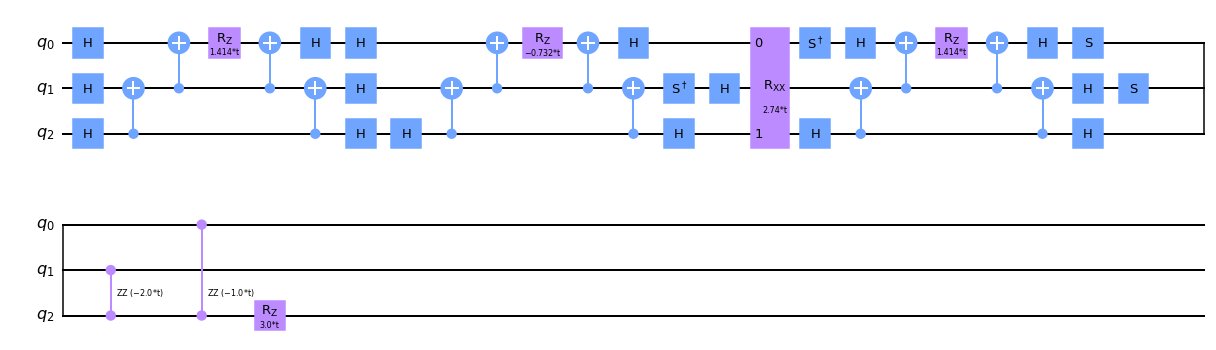

In [58]:
# evolution operator
evo_time = Parameter('t')
evolution_op = (evo_time * h_qiskit).exp_i()
trotterized_op = PauliTrotterEvolution(trotter_mode='trotter', reps=1).convert(evolution_op)
#trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(reps=reps, order=2)).convert(evolution_op)
qc_e = trotterized_op.to_circuit()  # evolution circuit
qc_e = qc_e.decompose().decompose()
qc_e.draw('mpl', filename=plot_folder + 'trotterized_unitary_circuit' + '.png')

### Extra

Comparison: exact unitary directly from Hamiltonian

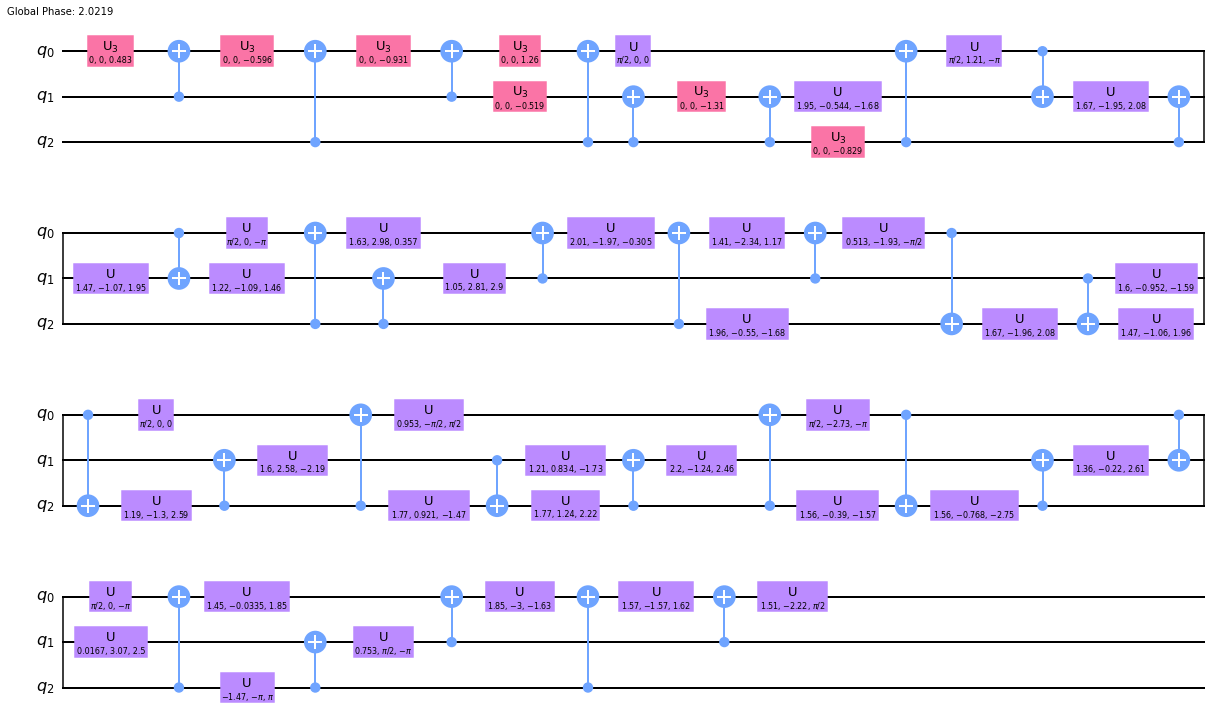

In [59]:
import scipy
t = 1
unitary = scipy.linalg.expm(-1j * t * hamiltonian)
# circuit
qc_unitary = QuantumCircuit(qubit_num)
qc_unitary.unitary(unitary, [x for x in range(qubit_num)])
# transpile
backend = QasmSimulator()
qc_unitary = transpile(qc_unitary, backend=backend, optimization_level=3)
qc_unitary = qc_unitary.decompose().decompose()
qc_unitary.draw('mpl', filename=plot_folder + 'exact_unitary_circuit' + '.png')

In [60]:
print('circuit depth exact unitary', qc_unitary.depth(), qc_unitary.count_ops())
print('circuit depth encoded unitary', qc_e.depth(), qc_e.count_ops())

circuit depth exact unitary 59 OrderedDict([('u', 36), ('cx', 31), ('u3', 7)])
circuit depth encoded unitary 26 OrderedDict([('h', 16), ('cx', 12), ('rz', 4), ('sdg', 2), ('s', 2), ('rzz', 2), ('rxx', 1)])


Example: time evolution using Qiskit Statevector

In [61]:
# fix the time for the circuit
qc_e = qc_e.bind_parameters({evo_time: 1})
# transpile the circuit
backend = QasmSimulator()
qc_e = transpile(qc_e, backend=backend, optimization_level=3)
# initial state
initial = Statevector.from_label('0' * qubit_num)
# evolve
evolved = initial.evolve(qc_e)

initial state
 [1. 0. 0. 0. 0. 0. 0. 0.]
evolved state
 [5.80818315e-02 2.42291700e-36 8.16819106e-01 1.64951147e-33
 5.18584060e-34 5.11262055e-03 6.72776173e-34 1.19986442e-01]


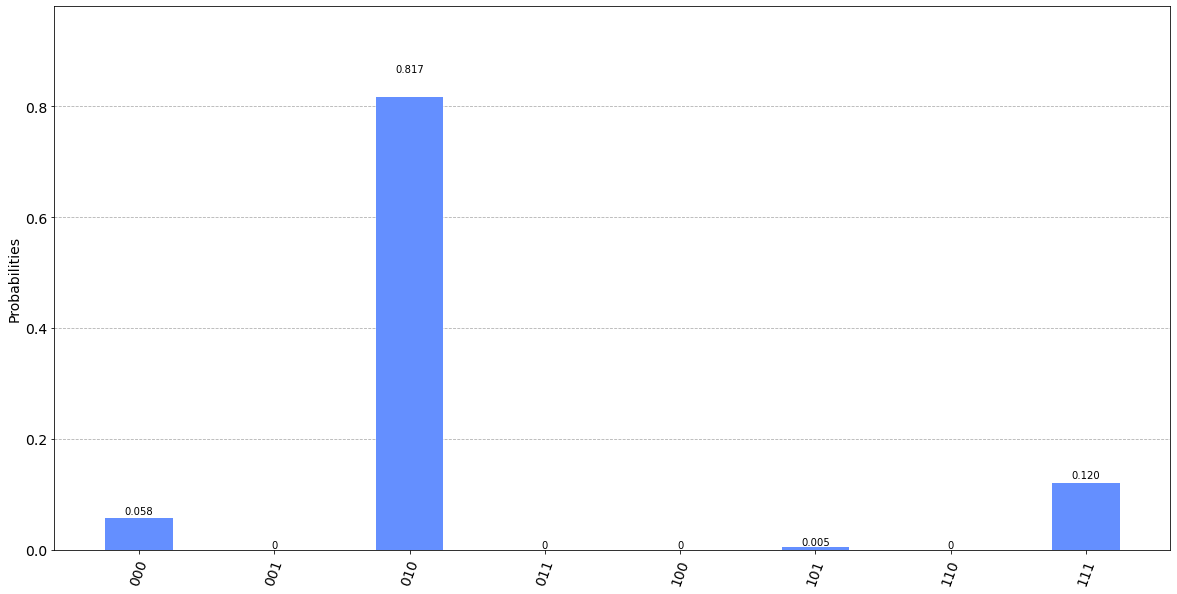

In [62]:
# result
print('initial state\n', initial.probabilities())
print('evolved state\n', evolved.probabilities())
plot_histogram(evolved.probabilities_dict(), figsize=(20, 10))